# INT

Download MILES spectra from: http://svocats.cab.inta-csic.es/miles/index.php?action=credits

Save them in a folder called "Miles" in the same directory of the notebook.

#### ACKNOWLEDGMENT
This work is based on data from the MILES service developed by the Spanish Virtual Observatory in the framework of the IAU Comission G5 Working Group : Spectral Stellar Libraries.

In [1]:
import os
from pathlib import Path
from astropy.io import fits
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from math import log2, pow
from music21 import *

import random
import pickle
import glob

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Input, Dropout, Dense, Activation, Embedding, Concatenate, Reshape
from tensorflow.keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from tensorflow.keras.layers import Multiply, Lambda, Softmax
import tensorflow.keras.backend as K 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tqdm.notebook import tqdm

import pygame.midi
import time
import librosa
from pythonosc import udp_client

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Checking the dataset

In [2]:
root = 'Miles'

In [3]:
file = 'Miles/miles_spec_fits_s0597.fits'

In [4]:
def check_data(file):
    sp = fits.open(file)
    print('\n\nHeader of the spectrum :\n\n', sp[0].header, '\n\n')

    flux = np.zeros(sp[0].header['NAXIS1'], dtype=float)

    flux = np.array(sp[0].data)
    flux_norm = flux/(np.nanmax(flux))

    wave = np.ones(sp[0].header['NAXIS1'], dtype=float)
    for i in range(sp[0].header['NAXIS1']):
        wave[i] = sp[0].header['CRVAL1'] + i*sp[0].header['CDELT1']

    flux_np = np.reshape(flux_norm, (sp[0].header['NAXIS1']))
    return(wave, flux_np)

In [5]:
def plot_spectra(wave, flux):
    fig = plt.figure(1, figsize=(12, 8))
    plt.plot(wave,flux)
    plt.xlabel('Wavelength [Å]')
    plt.ylabel('ADU')
    plt.title(file)
    plt.show()

In [6]:
wave, flux = check_data(file)



Header of the spectrum :

 SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    2 / number of data axes                            NAXIS1  =                 4367 / length of data axis 1                          NAXIS2  =                    1 / length of data axis 2                          COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H COMMENT ----------------------------------------------------------------------  COMMENT ************************** REDUCEME HEADER ***************************  COMMENT ----------------------------------------------------------------------  HISTORY Date: 06/10/**                                                          CRPIX1  =                 1.00                                                  CRVAL1  =  

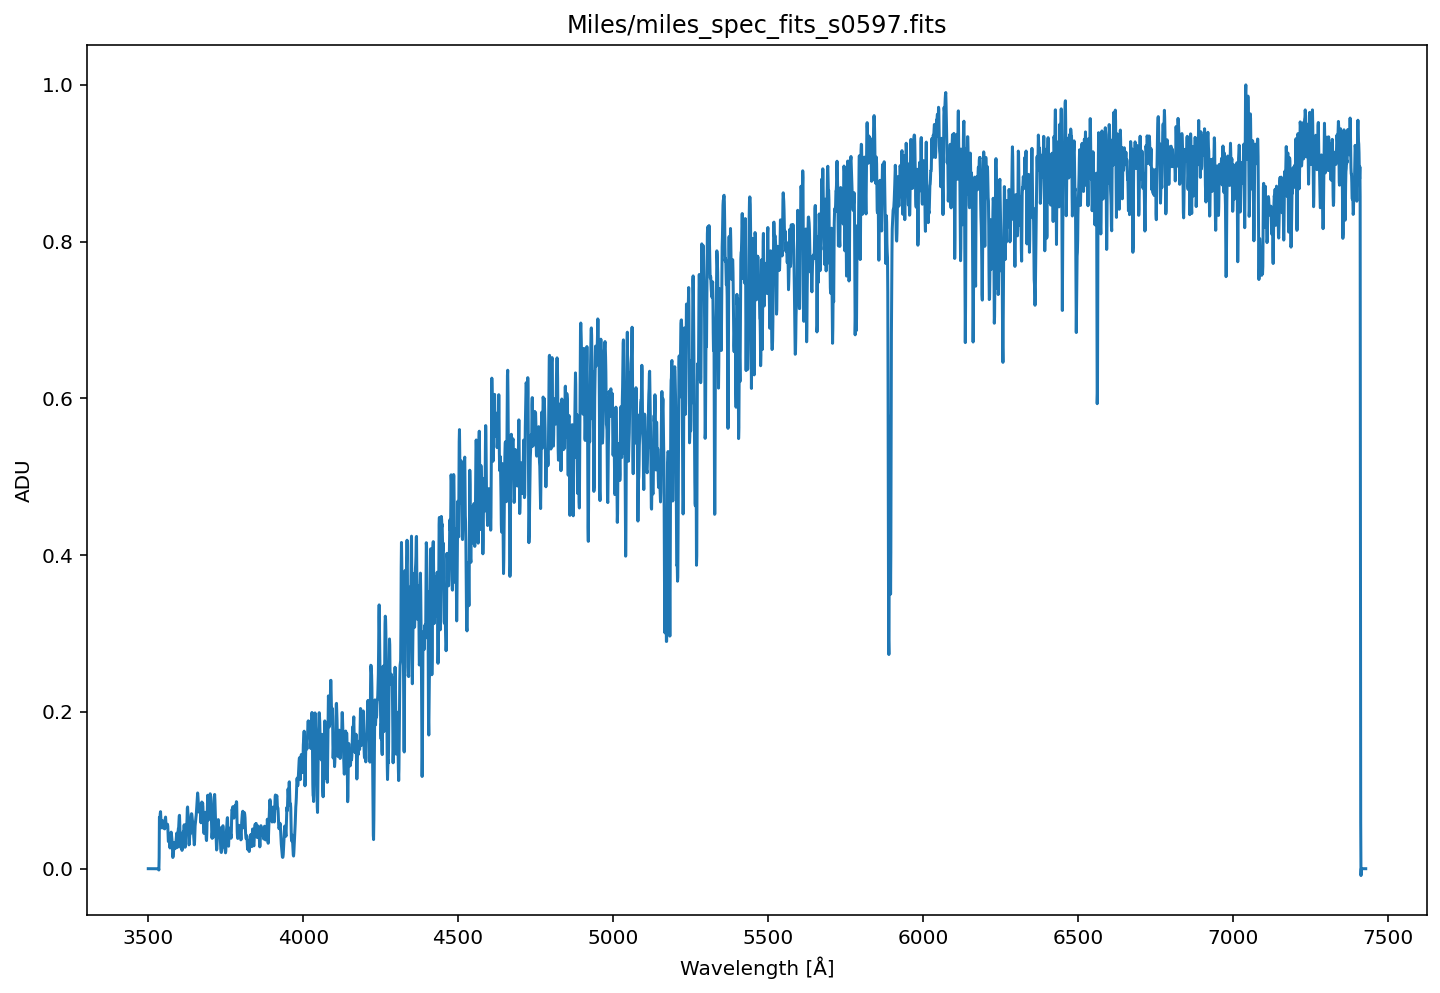

In [7]:
plot_spectra(wave, flux)

## Generating a custom dataset with the complete library


In [8]:
spectra = 1
for path, subdirs, files in os.walk(root):
    for name in files:
        spectra += 1

In [9]:
dim = len(flux)
print('Number of spectra: ', spectra)

Number of spectra:  985


In [10]:
def generate_dataset(root, num, dim):
    curves = 0
    custom_set = np.zeros((num, dim))
    label_set = np.zeros((num, ), dtype=int)
    spectra_set = [''] * num 

    for path, subdirs, files in os.walk(root):
        for name in files:
            file = [os.path.join(path, name)]
            str = " " 
            Ffile = (str.join(file))
            route = Path(name)

            data, header = fits.getdata(Ffile, header=True)
            hdu_number = 0
            fits.getheader(Ffile, hdu_number)
            fits_file = Ffile

            with fits.open(fits_file, mode='readonly') as hdulist:
                hdulist.info()
                data = np.array(hdulist[0].data)
                data_norm = np.reshape(data/(np.nanmax(data)), (dim))
                label_set[curves] = curves 
                spectra_set[curves] = name
                for i in range (dim):
                    custom_set[curves,i] = (data_norm[i])
            hdulist.close   
            curves += 1
    return(custom_set, label_set, spectra_set)

In [11]:
def split_dataset(custom_set, label_set):
    dataset = tf.data.Dataset.from_tensor_slices((custom_set, label_set))
    dataset.element_spec
    x_train,x_test,y_train,y_test=train_test_split(custom_set,label_set,test_size=0.2,random_state=123)
    return(x_train,x_test,y_train,y_test)

In [12]:
custom_set, label_set, spectra_set = generate_dataset(root, spectra, dim)
x_train,x_test,y_train,y_test = split_dataset(custom_set, label_set)

Filename: Miles/miles_spec_fits_s0597.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0981.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0578.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0082.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0128.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0201.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (43

Filename: Miles/miles_spec_fits_s0391.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0104.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0554.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0807.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0942.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0041.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (43

Filename: Miles/miles_spec_fits_s0132.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0325.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0775.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0260.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0630.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0519.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (43

Filename: Miles/miles_spec_fits_s0426.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0076.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0975.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0830.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0563.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0099.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (43

Filename: Miles/miles_spec_fits_s0685.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0390.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0810.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0543.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0113.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0406.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (43

Filename: Miles/miles_spec_fits_s0083.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0129.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0067.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0437.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0964.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0821.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (43

Filename: Miles/miles_spec_fits_s0677.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0948.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0765.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0335.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0620.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0270.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (43

Filename: Miles/miles_spec_fits_s0114.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0817.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0952.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0401.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0051.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0378.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (43

Filename: Miles/miles_spec_fits_s0545.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0115.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0816.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0953.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0400.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0050.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (43

Filename: Miles/miles_spec_fits_s0334.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0621.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0271.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0949.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0363.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0699.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (43

Filename: Miles/miles_spec_fits_s0123.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0573.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0089.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0858.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0622.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0272.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (43

Filename: Miles/miles_spec_fits_s0120.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0570.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0823.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0966.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0065.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0435.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (43

Filename: Miles/miles_spec_fits_s0839.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0585.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0301.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0751.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0244.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0614.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (43

Filename: Miles/miles_spec_fits_s0300.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0750.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0245.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0615.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0091.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0838.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (43

Filename: Miles/miles_spec_fits_s0121.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0571.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0822.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0967.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0064.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0434.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (43

Filename: Miles/miles_spec_fits_s0766.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0336.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0859.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0278.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0782.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0628.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (43

Filename: Miles/miles_spec_fits_s0242.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0612.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0491.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0868.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0887.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (43

Filename: Miles/miles_spec_fits_s0833.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0976.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0425.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0075.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0219.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0649.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (43

Filename: Miles/miles_spec_fits_s0920.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0218.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0648.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0561.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0131.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0832.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (43

Filename: Miles/miles_spec_fits_s0255.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0490.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0869.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0886.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0185.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0306.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (43

Filename: Miles/miles_spec_fits_s0279.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0783.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0629.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   
Filename: Miles/miles_spec_fits_s0296.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   


2025-02-07 19:29:42.862151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## VAE Definition

In [13]:
latent_dim = 4

In [14]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z"""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim), mean=0., stddev=0.1)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Encoder

In [15]:
intermediate_dim = dim/8
intermediate_dim2 = intermediate_dim/8
intermediate_dim3 = intermediate_dim2/8
intermediate_dim4 = intermediate_dim3/latent_dim

original_inputs = tf.keras.Input(shape=(dim,), name="encoder_input")
x1 = layers.Dense(intermediate_dim, activation="relu")(original_inputs)
x2 = layers.Dense(intermediate_dim2, activation="relu")(x1)
x3 = layers.Dense(intermediate_dim2, activation="relu")(x2)
x4 = layers.Dense(intermediate_dim2, activation="relu")(x3)

z_mean = layers.Dense(latent_dim, name="z_mean")(x4)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x4)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name="encoder")

### Decoder

In [16]:
latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_sampling")
x5 = layers.Dense(intermediate_dim2, activation="relu")(latent_inputs)
x6 = layers.Dense(intermediate_dim2, activation="relu")(x5)
x7 = layers.Dense(intermediate_dim2, activation="relu")(x6)
x8 = layers.Dense(intermediate_dim, activation="relu")(x7)


outputs = layers.Dense(dim, activation="sigmoid")(x8)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name="decoder")

### VAE

In [17]:
outputs = decoder(z)
vae = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="VAE-4D")

In [18]:
kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
vae.add_loss(kl_loss)

## Training

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=100, batch_size=2)

Epoch 1/100
394/394 [==============================] - 4s 10ms/step - loss: 0.0744
Epoch 2/100
394/394 [==============================] - 4s 10ms/step - loss: 0.0455
Epoch 3/100
394/394 [==============================] - 4s 10ms/step - loss: 0.0344
Epoch 4/100
394/394 [==============================] - 4s 9ms/step - loss: 0.0320
Epoch 5/100
394/394 [==============================] - 4s 10ms/step - loss: 0.0285
Epoch 6/100
394/394 [==============================] - 4s 9ms/step - loss: 0.0268
Epoch 7/100
394/394 [==============================] - 4s 10ms/step - loss: 0.0270
Epoch 8/100
394/394 [==============================] - 4s 10ms/step - loss: 0.0259
Epoch 9/100
394/394 [==============================] - 4s 10ms/step - loss: 0.0236
Epoch 10/100
394/394 [==============================] - 4s 10ms/step - loss: 0.0226
Epoch 11/100
394/394 [==============================] - 4s 10ms/step - loss: 0.0230
Epoch 12/100
394/394 [==============================] - 4s 10ms/step - loss: 0.0224
Epo

In [20]:
weights = vae.get_weights()
vae.save_weights('weights_VAE/Miles_VAE-4D_Weights', weights)

In [21]:
encoder.save('models/VAE-4D_Encoder.tf', save_format='tf')

INFO:tensorflow:Assets written to: models/VAE-4D_Encoder.tf/assets


In [22]:
decoder.save('models/VAE-4D_Decoder.tf', save_format='tf')

INFO:tensorflow:Assets written to: models/VAE-4D_Decoder.tf/assets


In [23]:
vae.save('models/VAE-4D.h5')

In [24]:
encoded_all = encoder(custom_set)
encoded_spectra=encoded_all.numpy()

np.save('output/encoded_spectra.npy', encoded_spectra)

In [25]:
encoded_train = encoder(x_train)

In [26]:
decoded_train = vae(x_train)

In [27]:
encoded_test = encoder(x_test)

In [28]:
decoded_test = vae(x_test)

In [29]:
vae.summary()

Model: "VAE-4D"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 4367)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 545)          2380560     ['encoder_input[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 68)           37128       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 68)           4692        ['dense_1[0][0]']                
                                                                                             

## Calculating R2

In [30]:
r2_score(x_train, decoded_train, multioutput='variance_weighted') # training set

0.7803086006382219

In [31]:
r2_score(x_test, decoded_test, multioutput='variance_weighted') # test set

0.8121752776094876

## Calculating Chord durations

In [32]:
latent_spectra = np.abs(np.fix(encoded_spectra*10).astype(int))
spectra_durations = [np.sum(latent_spectra[i]) for i in range (spectra)]
np.save('output/spectra_durations.npy', spectra_durations)

## Calculating Chords

In [33]:
ranged_spectra = 1000*np.add(encoded_spectra,0.9) #adjusts values to piano range: 27.5 Hz (A0) to 4186 Hz (C8)

In [34]:
def freq2note(f):
    note = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    tuning = 440
    C0 = tuning*pow(2, -57/12) # C0 frequency from tuning reference
    h = round(12*log2(f/C0)) #semitones from C0
    octave = h // 12 # octave 
    n = h % 12 # semitones to C
    return note[n] + str(octave)

In [35]:
encoded_notes = (np.ones((spectra, 4), dtype=float)).astype(str)

In [36]:
for i in range(spectra):
    for j in range(4):
        encoded_notes[i][j] = freq2note(ranged_spectra[i][j])

In [37]:
chords = [[] for _ in encoded_notes]
for i in range(spectra):
    for j in range(4):
        chords[i].append(encoded_notes[i][j])
np.save('output/spectra_chords.npy', chords)

In [38]:
len(encoded_notes)

985

In [39]:
len(chords)

985

## Miles "chordification"

In [40]:
score1 = stream.Stream()
n = 120
score1.append(tempo.MetronomeMark(number=n))

durations = ["whole","half", "quarter", "eighth"]
for i in range(spectra):
    if spectra_durations[i] >= 12:
        figure = durations[0]
    if (spectra_durations[i] >= 8) and (spectra_durations[i] < 12):
        figure = durations[1]
    if (spectra_durations[i] > 4) and (spectra_durations[i] <= 8):
        figure = durations[2]
    if spectra_durations[i] <= (4):
        figure = durations[3]
    
    exec(f'n{i} = chord.Chord(chords[i])')
    exec(f'n{i}.duration.type = figure')
    

dlopen error : dlopen(libjack.0.dylib, 1): image not found 
dlopen error : dlopen(/usr/local/lib/libjack.0.dylib, 1): no suitable image found.  Did find:
	/usr/local/lib/libjack.0.dylib: code signature in (/usr/local/lib/libjack.0.dylib) not valid for use in process using Library Validation: mapped file has no cdhash, completely unsigned? Code has to be at least ad-hoc signed. 
Creating main window…
ZoomBox::setLogicalZoom(): Formatting logical zoom level as 100% (rounded from 1.000000)
Reading translations…
convert </var/folders/jw/nr9685ns4r32q0t030hxmzlw0000gn/T/music21/tmph3g1ymaf.xml>...
JIT is disabled for QML. Property bindings and animations will be very slow. Visit https://wiki.qt.io/V4 to learn about possible solutions for your platform.
	to </var/folders/jw/nr9685ns4r32q0t030hxmzlw0000gn/T/music21/tmph3g1ymaf.png>
... success!


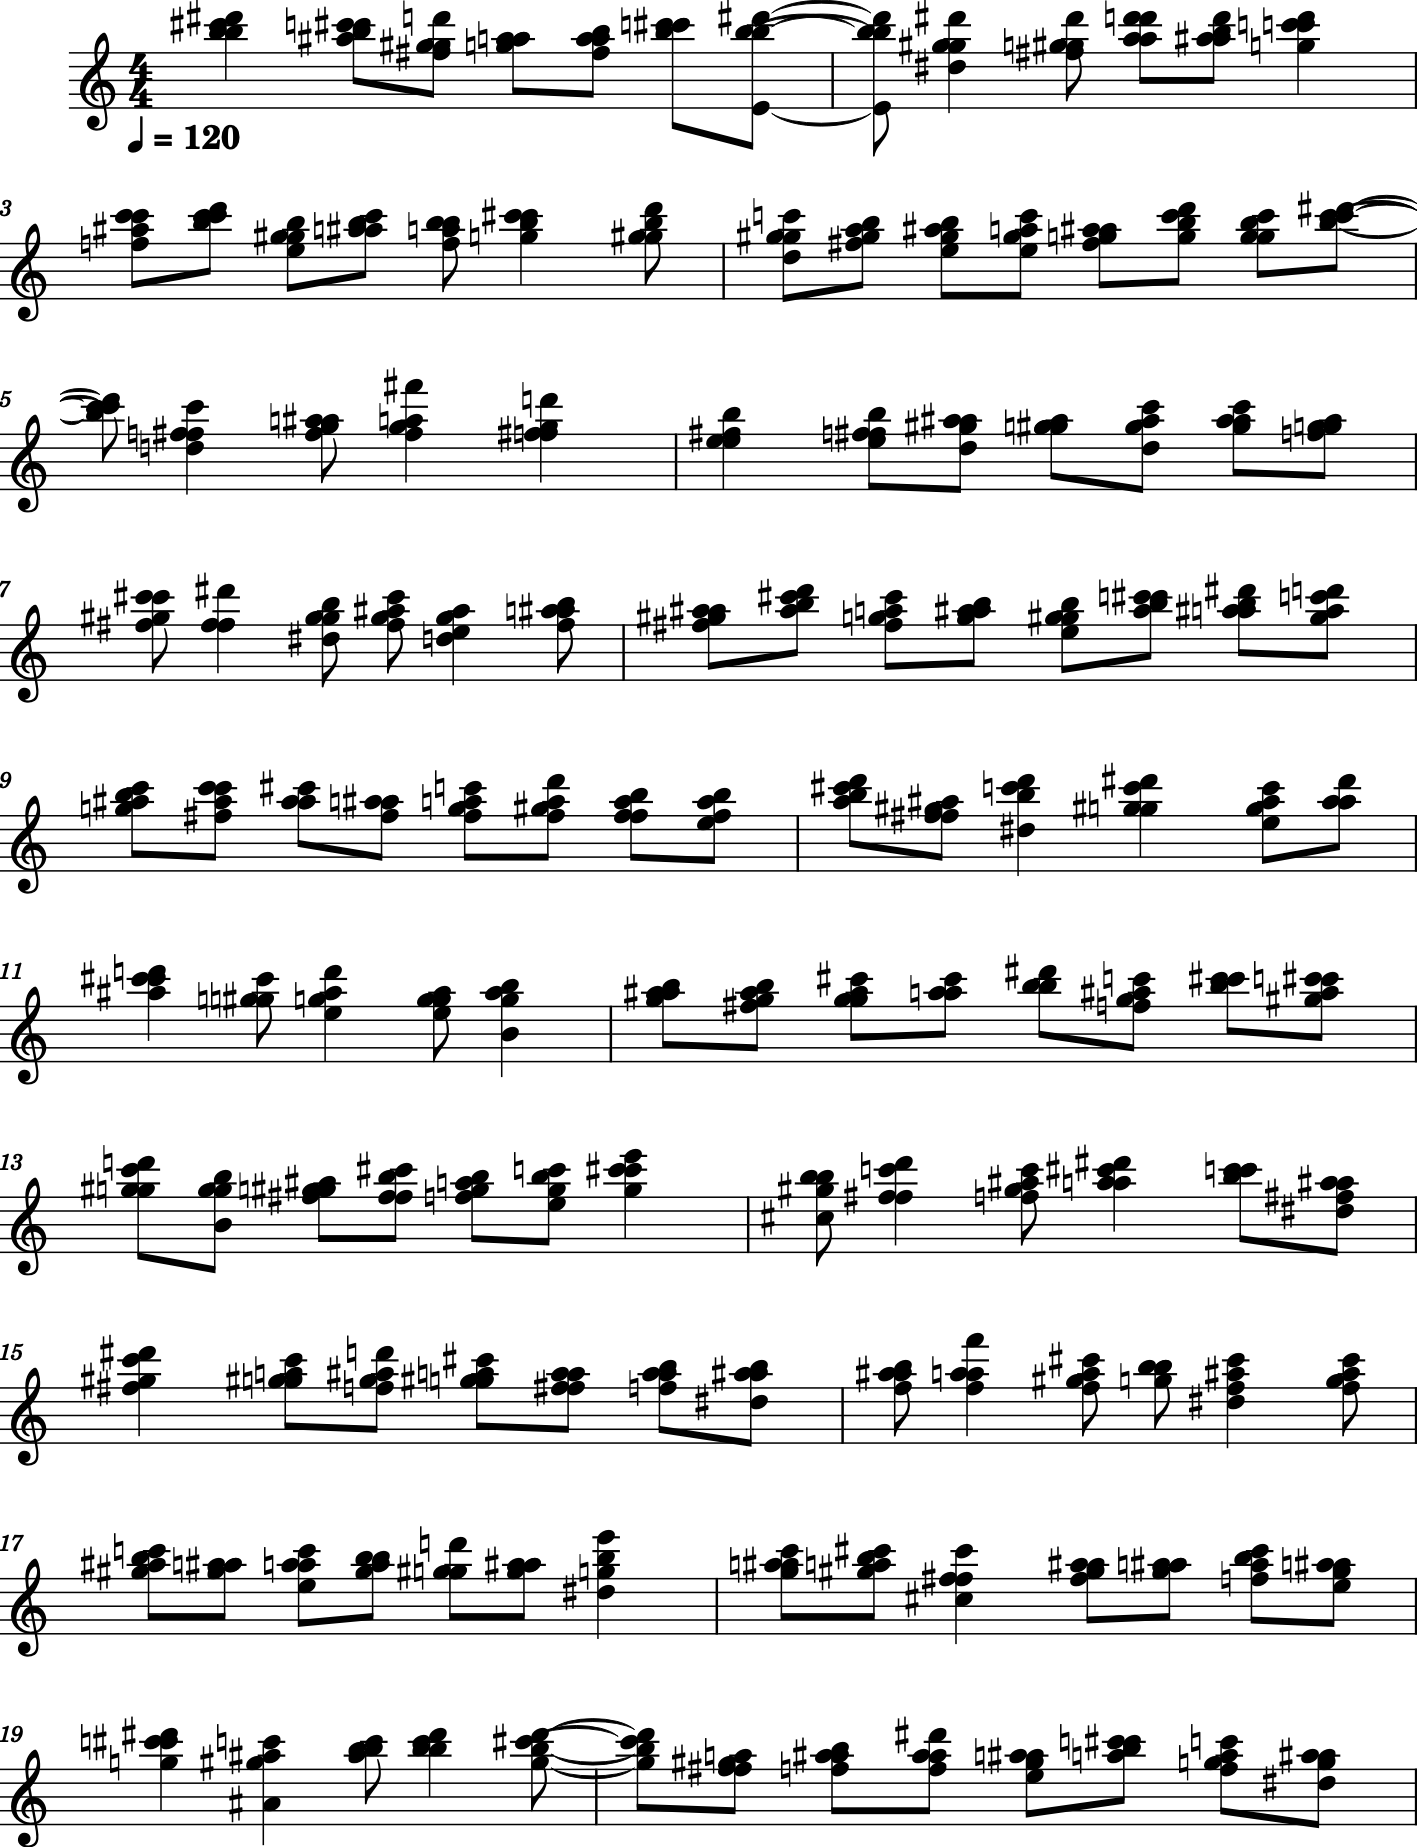

In [41]:
for k in range(spectra):
    exec(f'score1.append(n{k})')
score1.show()

In [42]:
score1.write('midi', fp='scores/score1.mid')

'scores/score1.mid'

## Loading Chopin's "Prelude in C sharp minor, Op. 45"
Download MIDI file from: https://www.kunstderfuge.com/chopin.htm

Live and sequenced (quality) by © Dr. Ron Lubetsky

Save it in a folder called "MIDI" in the same directory of the notebook.

In [43]:
data_dir = 'MIDI'

midi_list = os.listdir(data_dir)

test_scores = []
for midi in tqdm(midi_list):
    score = converter.parse(os.path.join(data_dir,midi))
    test_scores.append(score)

  0%|          | 0/1 [00:00<?, ?it/s]

In [44]:
midi_list

['chopin_prelude_45_(c)lubetsky.midi']

In [45]:
test_scores = [midi.chordify() for midi in tqdm(test_scores)]

  0%|          | 0/1 [00:00<?, ?it/s]

In [46]:
test_chords = [[] for _ in test_scores]
test_durations = [[] for _ in test_scores]
test_keys = []

for i, midi in tqdm(enumerate(test_scores)):
    test_keys.append(str(midi.analyze('key')))
    for element in midi:
        if isinstance(element, note.Note):
            test_chords[i].append(element.pitch)
            test_durations[i].append(element.duration.quarterLength)
        elif isinstance(element, chord.Chord):
            test_chords[i].append('.'.join(str(n) for n in element.pitches))
            test_durations[i].append(element.duration.quarterLength)

0it [00:00, ?it/s]

In [47]:
def get_distinct(elements):
    # Get all pitch names
    element_names = sorted(set(elements))
    n_elements = len(element_names)
    return (element_names, n_elements)

def create_lookups(element_names):
    # create dictionary to map notes and durations to integers
    element_to_int = dict((element, number) for number, element in enumerate(element_names))
    int_to_element = dict((number, element) for number, element in enumerate(element_names))

    return (element_to_int, int_to_element)

In [48]:
try: 
    store_folder = 'parsed_data_Prelude'
    os.mkdir(store_folder)
except:
    print("Folder already exits")

Folder already exits


In [49]:
note_names, n_notes = get_distinct([n for chord in test_chords for n in chord])
duration_names, n_durations = get_distinct([d for dur in test_durations for d in dur])
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

In [50]:
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [51]:
print("Unique Notes={} and Duration values={}".format(n_notes,n_durations))

Unique Notes=1102 and Duration values=21


## Building up 'initial_chords' via 'train_chords'

In [52]:
sequence_length = 300

train_chords = []
train_durations = []
for s in range(len(test_chords)):
    chord_list = [note_to_int[c] for c in test_chords[s]]# 'chord_list' codification with 'note to int'
    duration_list = [duration_to_int[d] for d in test_durations[s]]# duration codification with 'duration to int'
    for i in range(len(chord_list) - sequence_length):
        train_chords.append(chord_list[i:i+sequence_length])
        train_durations.append(duration_list[i:i+sequence_length])

train_chords = np.array(train_chords)
train_durations = np.array(train_durations)

## Building up the pretrained Model

In [53]:
def network(n_notes, n_durations, embed_size = 100, rnn_units = 256):

    notes_in = Input(shape = (None,))
    durations_in = Input(shape = (None,))

    x1 = Embedding(n_notes, embed_size)(notes_in)
    x2 = Embedding(n_durations, embed_size)(durations_in) 

    x = Concatenate()([x1,x2])

    x = LSTM(rnn_units, return_sequences=True)(x)

    x = LSTM(rnn_units, return_sequences=True)(x)

    # attention
    e = Dense(1, activation='tanh')(x)
    e = Reshape([-1])(e)
    alpha = Activation('softmax')(e)

    alpha_repeated = Permute([2, 1])(RepeatVector(rnn_units)(alpha))

    c = Multiply()([x, alpha_repeated])
    c = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(rnn_units,))(c)
    
                                    
    notes_out = Dense(n_notes, activation = 'softmax', name = 'pitch')(c)
    durations_out = Dense(n_durations, activation = 'softmax', name = 'duration')(c)
   
    model = Model([notes_in, durations_in], [notes_out, durations_out])
    model.compile(loss=['sparse_categorical_crossentropy', 
                        'sparse_categorical_crossentropy'], optimizer=RMSprop(learning_rate= 0.001))#before "lr=0.001"

    return model

In [54]:
embed_size = 128
rnn_units = 128

In [55]:
model = network(82231, 118, embed_size, rnn_units)

In [56]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 128)    10525568    ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 128)    15104       ['input_2[0][0]']                
                                                                                              

## Loading LSTM weights

Download the precalculated weights from: https://zenodo.org/records/8342535

Save the file in a folder called "Weights_LSTM"

In [57]:
model.load_weights('Weights_LSTM/Weights_AI-rmonizer.h5')

# Generating Music

In [58]:
def sample_with_temp(preds, temperature):

    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [59]:
initial_chords = np.expand_dims(train_chords[0,:].copy(), 0)
initial_durations = np.expand_dims(train_durations[0,:].copy(), 0)

In [60]:
def predict_chords(chord_sequence, duration_sequence,model,temperature=0.8):
    predicted_chords, predicted_durations = model.predict([chord_sequence, duration_sequence])
    return sample_with_temp(predicted_chords[0],temperature), sample_with_temp(predicted_durations[0],temperature)

In [61]:
new_chords, new_durations = [], []

for j in range(sequence_length-1):
    new_chord, new_duration = predict_chords(initial_chords, 
                                             initial_durations,
                                             model,
                                             temperature=0.8)
    new_chords.append(new_chord)
    new_durations.append(new_duration)
    initial_chords[0][:-1] = initial_chords[0][1:]
    initial_chords[0][-1] = new_chord
    initial_durations[0][:-1] = initial_durations[0][1:]
    initial_durations[0][-1] = new_duration

1/1 [==============================] - 0s 39ms/step


/var/folders/jw/nr9685ns4r32q0t030hxmzlw0000gn/T/ipykernel_76967/349567576.py:6: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature


1/1 [==============================] - 0s 37ms/step


# Solving lack of new chords and durations generated 

In [62]:
original_chords = np.load('pre-calculated/original_chords_MAESTRO.npy', allow_pickle=True)
original_durations = np.load('pre-calculated/original_durations_MAESTRO.npy', allow_pickle=True)

In [63]:
note_names, n_notes = get_distinct([n for chord in original_chords for n in chord])
duration_names, n_durations = get_distinct([d for dur in original_durations for d in dur])
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

In [64]:
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [65]:
print("Unique Notes={} and Duration values={}".format(n_notes,n_durations))

Unique Notes=82231 and Duration values=118


In [66]:
durations_OK = new_durations
for i in range(len(new_durations)):
    try:
        durations_OK[i]= int_to_duration[new_durations[i]]
    except:
        durations_OK[i]=0.25

In [67]:
for i in range(len(new_durations)):
    print(durations_OK[i])

1/12
1/6
1/12
1/12
1/6
1/6
1/6
0.25
5/12
0.25
1/12
1/6
0.75
0.75
1/12
1/12
1/12
0.75
1/6
1/6
1.0
0.25
1/12
1/12
0.25
0.25
1/6
1/12
1/6
1/12
1/6
1/12
0.25
1/6
1/3
1/6
1/6
1/6
1/6
1/3
1/3
1/3
1/12
0.25
1/12
0.25
1/12
0.75
1/3
1/6
1/6
1/6
0.25
1/12
1/12
1/12
0.25
1/12
1/12
0.25
1/12
0.5
0.25
1/12
1/6
0.25
1/3
1/6
0.25
1/12
1/6
1/12
1/6
1/12
1/6
1/12
1/6
1/6
1/6
1/6
1/3
1/6
1/6
1/12
1/12
1/6
0.25
1/6
1/12
0.25
1/12
1/6
0.25
0.25
1/12
1/12
1/12
0.25
0.25
1/12
5/12
0.25
1/6
1/6
1/6
1/12
1/6
1/12
1/12
0.25
1/12
1/12
1/12
1/6
1/12
1/3
0.25
1/12
1/6
0.5
0.25
0.25
1/12
5/12
0.25
1/12
1/12
1/3
1/6
0.25
1/12
1/6
0.25
0.25
1/12
1/12
1/6
1/6
1/6
1/6
1/6
0.25
1/12
0.25
1/6
1/12
1/6
1/12
0.5
0.5
0.25
1/12
5/12
1/12
1/6
1/12
1/12
1/12
1/12
1/3
0.25
1/12
1/3
1/3
0.75
1/6
1/12
0.25
1/12
1/6
5/12
0.5
0.25
1/12
1/6
0.25
0.25
1/12
1/6
0.25
1/12
1/6
0.25
0.25
1/6
1/12
1/12
1/6
0.5
1/6
1/12
0.25
0.25
0.25
1/12
1/6
1/12
1/6
1/12
1/6
0.5
1/12
1/12
1/3
1/12
1/3
0.25
1/12
0.25
1/12
1/3
0.25
1/12
1/6
1/6
1/12
0.25

In [68]:
durations_OK = np.array(durations_OK, dtype=float)

# Generating music score

In [69]:
generated_stream = stream.Stream()
generated_stream.append(instrument.Piano())

dur_notes = ["whole","half", "quarter", "eighth"]

for j in range(len(new_chords)):
    
    if durations_OK[j] > 2:
        figure = dur_notes[0]
    if (durations_OK[j] > 1) and (durations_OK[j] <= 2):
        figure = dur_notes[1]
    if (durations_OK[j] > 0.5) and (durations_OK[j] <= 1):
        figure = dur_notes[2]
    if durations_OK[j] <= 0.5:
        figure = dur_notes[3]
       
    try:
        generated_stream.append(note.Note(int_to_note[new_chords[j]].replace('.', ' '), 
                                          type = figure))
    except:
        generated_stream.append(chord.Chord(int_to_note[new_chords[j]].replace('.', ' '), 
                                          type = figure))

midi_score = generated_stream.write('midi', fp='lstm_Maestro_Prelude.mid')

In [70]:
midi_score = converter.parse('lstm_Maestro_Prelude.mid').chordify()

dlopen error : dlopen(libjack.0.dylib, 1): image not found 
dlopen error : dlopen(/usr/local/lib/libjack.0.dylib, 1): no suitable image found.  Did find:
	/usr/local/lib/libjack.0.dylib: code signature in (/usr/local/lib/libjack.0.dylib) not valid for use in process using Library Validation: mapped file has no cdhash, completely unsigned? Code has to be at least ad-hoc signed. 
Creating main window…
ZoomBox::setLogicalZoom(): Formatting logical zoom level as 100% (rounded from 1.000000)
Reading translations…
convert </var/folders/jw/nr9685ns4r32q0t030hxmzlw0000gn/T/music21/tmpu4h5k4sf.xml>...
JIT is disabled for QML. Property bindings and animations will be very slow. Visit https://wiki.qt.io/V4 to learn about possible solutions for your platform.
	to </var/folders/jw/nr9685ns4r32q0t030hxmzlw0000gn/T/music21/tmpu4h5k4sf.png>
... success!


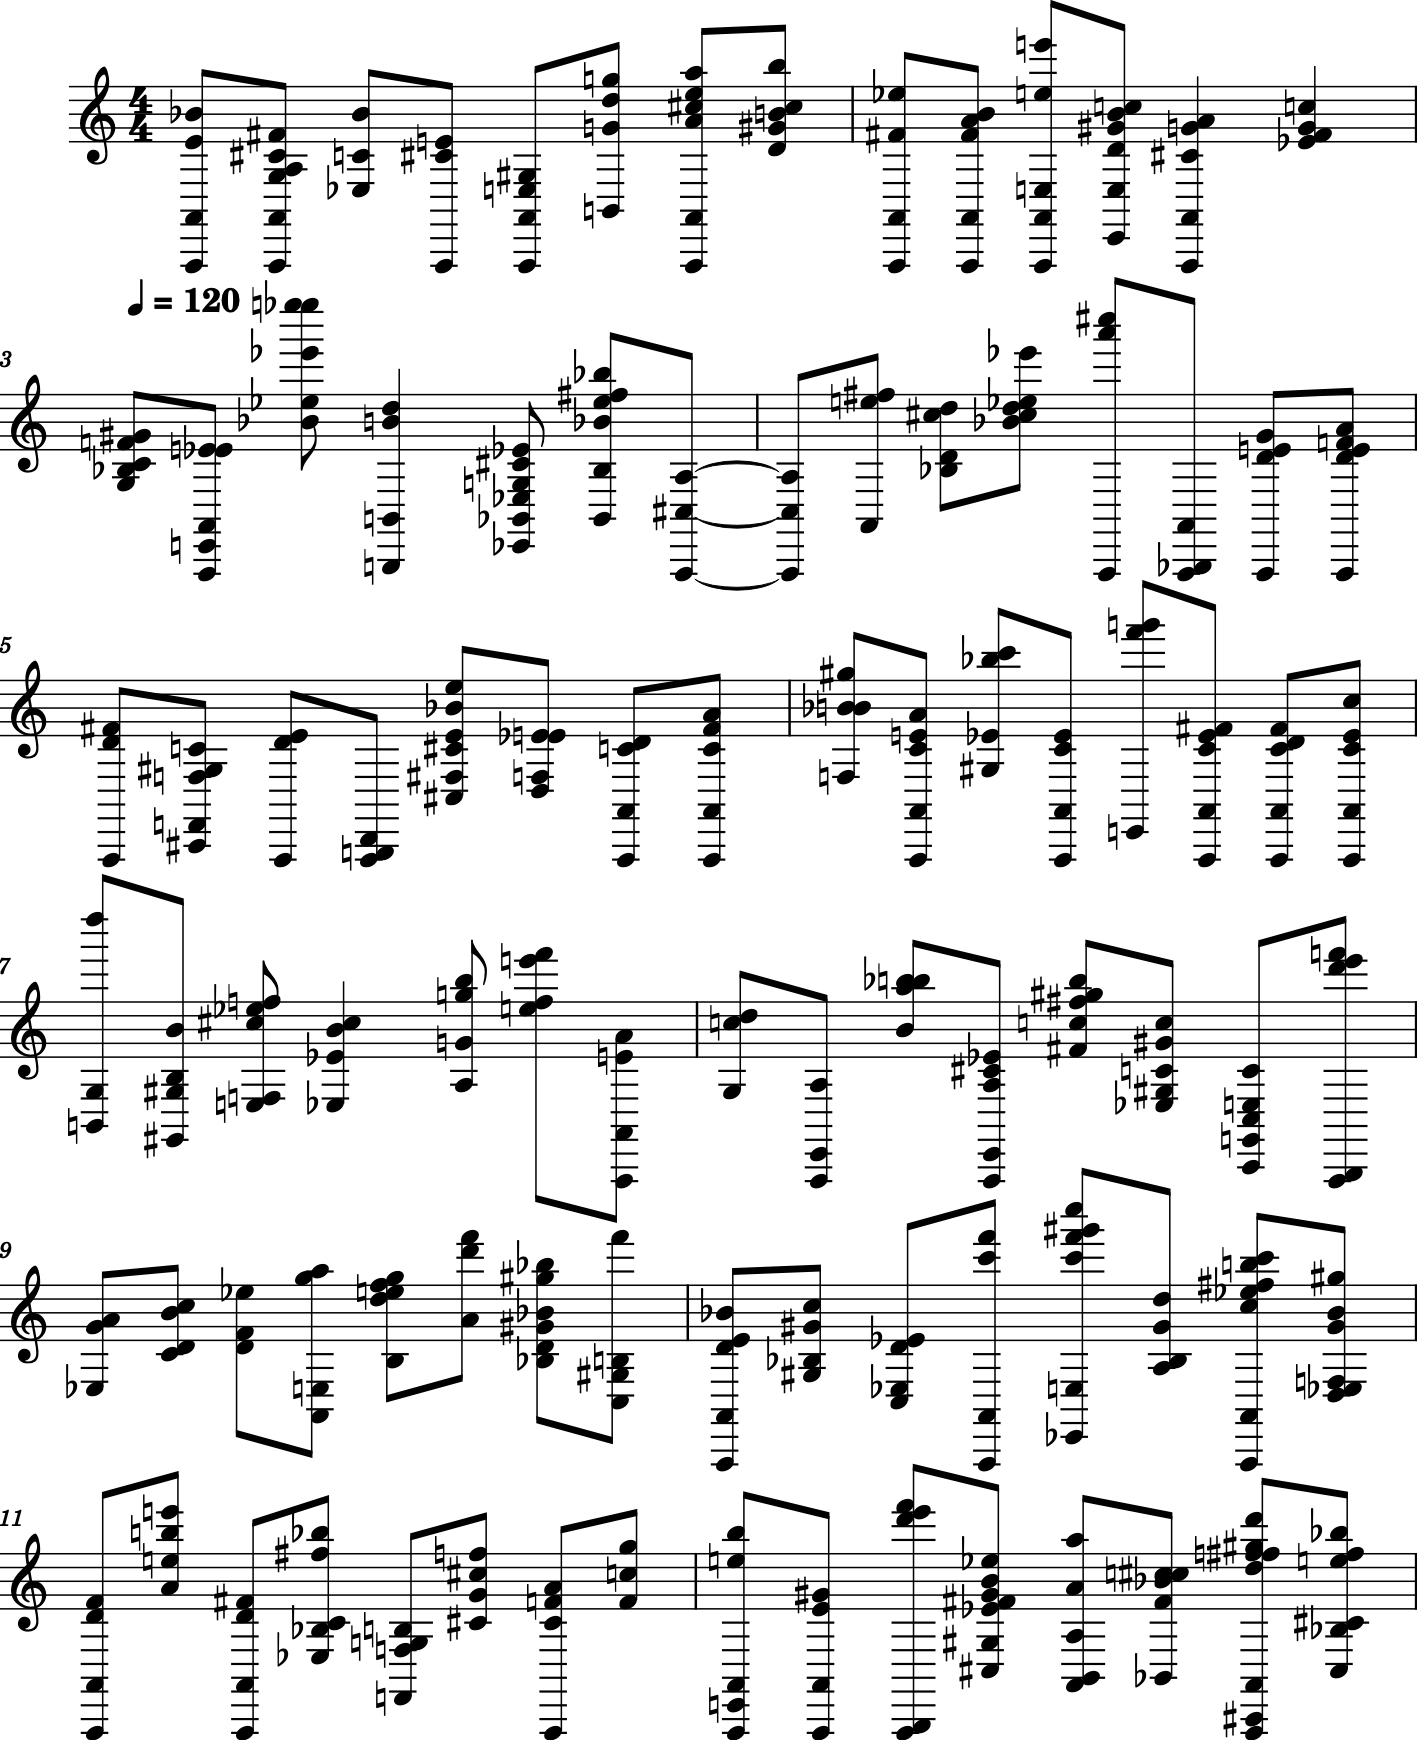

In [71]:
midi_score.show()

In [72]:
new_chords_OK = new_chords
for j in range(len(new_chords)):
    new_chords_OK[j] = int_to_note[new_chords[j]].replace('.', ' ')

In [73]:
np.save('output/new_chords', new_chords_OK)

In [74]:
np.save('output/new_durations', new_durations)

# Pitch Class Set Theory crossmatch

In [75]:
spectra_chords = np.load('output/spectra_chords.npy', allow_pickle=True)
spectra_durations = np.load('output/spectra_durations.npy', allow_pickle=True)

In [76]:
spectra_strings = np.array(['A0' for _ in range(len(spectra_chords))], dtype=object)

In [77]:
for i in range(spectra):
    spectra_strings[i] = (spectra_chords[i][0] + ' ' + spectra_chords[i][1] + ' ' + spectra_chords[i][2]+ ' ' + spectra_chords[i][3])

In [78]:
final_chords = np.array(['A0' for _ in range(len(new_chords))], dtype=object)

In [79]:
for i in range(len(new_chords)):
    for j in range(len(spectra_strings)):
        if spectra_strings[j] == new_chords[i]:
            final_chords[i] = spectra_strings[j]

In [80]:
spectra_reff = np.zeros(len(new_chords), dtype=int)
for i in range(len(new_chords)):
    for j in range(len(spectra_strings)):
        try:
            chord1 = chord.Chord(new_chords[i])
            chord2 = chord.Chord(spectra_chords[j])
            if chord2.orderedPitchClassesString == chord1.orderedPitchClassesString:
                final_chords[i] = spectra_strings[j]
                spectra_reff[i] = j
        except:
            print(j)
            j=len(spectra_strings)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [81]:
np.save('output/spectra_reff', spectra_reff)

## Adding star names to the score

In [82]:
def get_names(root, spectra_reff):
    objects = []
    num = 1
    for path, subdirs, files in os.walk(root):
        for name in files:
            num += 1
            
    for i in range(len(spectra_reff)):
        try:
            target = files[spectra_reff[i]]
            file = root+'/'+target
            print(i)
            print(file)
            sp = fits.open(file)
            objects.append(sp[0].header['OBJECT'])
            sp.close

        except:
            target = files[spectra_reff[i-1]]
            file = root+'/'+target
            print(i)
            print('Error')
            sp = fits.open(file)
            objects.append(sp[0].header['OBJECT'])
            sp.close
    return (objects)

In [83]:
object_names = get_names(root, spectra_reff)

0
Miles/miles_spec_fits_s0142.fits
1
Miles/miles_spec_fits_s0057.fits
2
Miles/miles_spec_fits_s0038.fits
3
Miles/miles_spec_fits_s0841.fits
4
Miles/miles_spec_fits_s0422.fits
5
Miles/miles_spec_fits_s0957.fits
6
Miles/miles_spec_fits_s0841.fits
7
Miles/miles_spec_fits_s0531.fits
8
Miles/miles_spec_fits_s0613.fits
9
Miles/miles_spec_fits_s0137.fits
10
Miles/miles_spec_fits_s0597.fits
11
Miles/miles_spec_fits_s0597.fits
12
Miles/miles_spec_fits_s0014.fits
13
Miles/miles_spec_fits_s0286.fits
14
Miles/miles_spec_fits_s0597.fits
15
Miles/miles_spec_fits_s0597.fits
16
Miles/miles_spec_fits_s0605.fits
17
Miles/miles_spec_fits_s0195.fits
18
Miles/miles_spec_fits_s0346.fits
19
Miles/miles_spec_fits_s0597.fits
20
Miles/miles_spec_fits_s0574.fits
21
Miles/miles_spec_fits_s0597.fits
22
Miles/miles_spec_fits_s0194.fits
23
Miles/miles_spec_fits_s0597.fits
24
Miles/miles_spec_fits_s0574.fits
25
Miles/miles_spec_fits_s0444.fits
26
Miles/miles_spec_fits_s0597.fits
27
Miles/miles_spec_fits_s0597.fits
28

In [84]:
np.save('output/final_chords.npy', final_chords)

# Generating the final Polyphonic Stellar Score

In [85]:
bpm = 90

In [86]:
def final_score (final_chords, bpm):
    string_notes = final_chords
    dim_string = len(string_notes)
    for i in range(dim_string):
        if string_notes[i] == "A0":
            string_notes[i] = "A0 A0 A0 A0"
    encoded_notes = np.empty([dim_string, latent_dim], dtype=object)
    for i in range(dim_string):
        notes = string_notes[i].split()
        notes = np.array(notes)
        for j in range(len(notes)):
            encoded_notes[i][j] = notes[j]
    chords = [[] for _ in encoded_notes]
    for i in range(dim_string):
        for j in range(4):
            chords[i].append(encoded_notes[i][j])

    score = stream.Score()
    score.append(tempo.MetronomeMark(number=bpm))

    a = stream.Part()
    a.append(tempo.MetronomeMark(number=bpm))
    score.insert(0,a)
    b = stream.Part()
    b.append(tempo.MetronomeMark(number=bpm))
    score.insert(1,b)
    c = stream.Part()
    c.append(tempo.MetronomeMark(number=bpm))
    score.insert(2,c)
    d = stream.Part()
    d.append(tempo.MetronomeMark(number=bpm))
    score.insert(3,d)
    
    durations = ["whole","half", "quarter", "eighth", "dottedHalf"]
    for i in range(len(chords)):

        if spectra_durations[spectra_reff[i]] > 2:
            figure = 0
        if ((spectra_durations[spectra_reff[i]] > 1) & (spectra_durations[spectra_reff[i]] <= 2)):
            figure = 1
        if ((spectra_durations[spectra_reff[i]] > 0.5) & (spectra_durations[spectra_reff[i]] <= 1)):
            figure = 2
        if spectra_durations[spectra_reff[i]] <= 0.5:
            figure = 3

        exec(f'm{i} = note.Note(chords[i][0])')
        exec(f'm{i}.duration.type = durations[figure]')

        exec(f'n{i} = note.Note(chords[i][1])')
        exec(f'n{i}.duration.type = durations[figure]')

        exec(f'o{i} = note.Note(chords[i][2])')
        exec(f'o{i}.duration.type = durations[figure]')

        exec(f'p{i} = note.Note(chords[i][3])')
        exec(f'p{i}.duration.type = durations[figure]')
        exec(f'p{i}.lyric = object_names[i]')# Adding the name of the object that generates the chord


        if chords[i][0] == "A0":
            exec(f'm{i} = note.Rest(chords[i][0], quarterLength= 3)')

            exec(f'n{i} = note.Rest(chords[i][0], quarterLength= 3)')

            exec(f'o{i} = note.Rest(chords[i][0], quarterLength= 3)')

            exec(f'p{i} = note.Rest(chords[i][0], quarterLength= 3)')
    for k in range(dim_string):
        if chords[k][0] != "A0": #Omiting silences
            exec(f'a.append(n{k})')
            exec(f'b.append(m{k})')
            exec(f'c.append(o{k})')
            exec(f'd.append(p{k})')
    return(score)

In [87]:
score = final_score(final_chords, bpm)

dlopen error : dlopen(libjack.0.dylib, 1): image not found 
dlopen error : dlopen(/usr/local/lib/libjack.0.dylib, 1): no suitable image found.  Did find:
	/usr/local/lib/libjack.0.dylib: code signature in (/usr/local/lib/libjack.0.dylib) not valid for use in process using Library Validation: mapped file has no cdhash, completely unsigned? Code has to be at least ad-hoc signed. 
Creating main window…
ZoomBox::setLogicalZoom(): Formatting logical zoom level as 100% (rounded from 1.000000)
Reading translations…
convert </var/folders/jw/nr9685ns4r32q0t030hxmzlw0000gn/T/music21/tmpq85nzn9e.xml>...
Error at line 4183 col 18: duplicate tempo at tick 0
Error at line 8393 col 18: duplicate tempo at tick 0
Error at line 12551 col 18: duplicate tempo at tick 0
JIT is disabled for QML. Property bindings and animations will be very slow. Visit https://wiki.qt.io/V4 to learn about possible solutions for your platform.
	to </var/folders/jw/nr9685ns4r32q0t030hxmzlw0000gn/T/music21/tmpq85nzn9e.png>
...

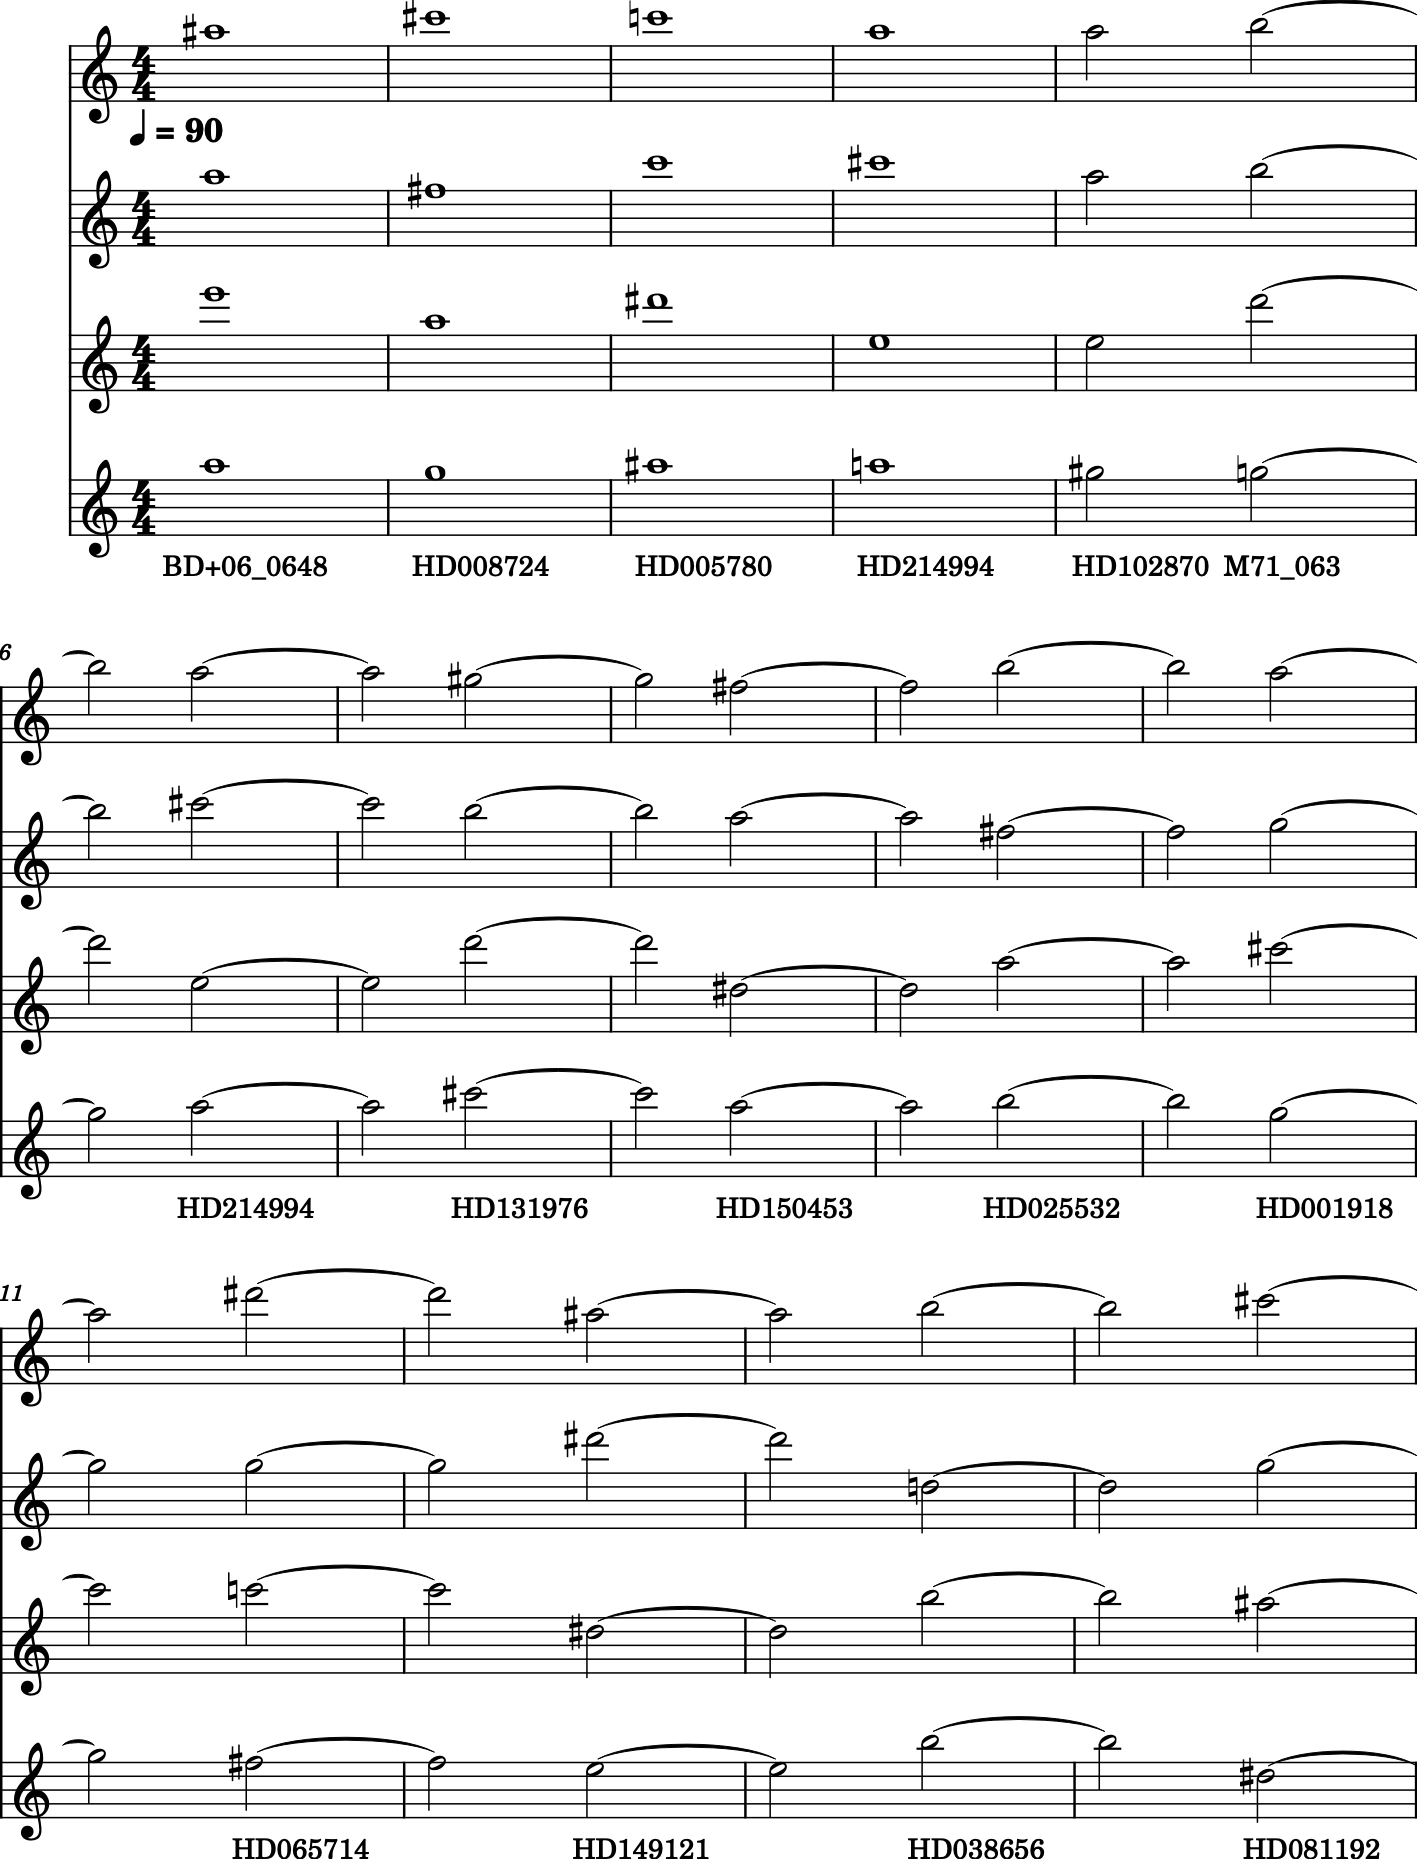

In [88]:
score.show()

In [89]:
score.write('midi', fp='Spectral_Prelude.mid')

'Spectral_Prelude.mid'

In [90]:
score.show('musicxml')

## "Real Time" generation

In [91]:
pygame.midi.init()
pygame.midi.get_count() #gets the number of devices

8

In [92]:
flux_norm = np.zeros((len(spectra_reff), dim), dtype=float)# To manage pre-calculated spectra

In [93]:
flux_norm.shape

(299, 4367)

In [94]:
sp = fits.open(file)
test = np.array(sp[0].data)
test.shape

(1, 4367)

In [95]:
len(files)

984

In [96]:
flux_norm.shape

(299, 4367)

In [97]:
len(spectra_reff)

299

In [98]:
spectra_reff[297]

0

In [99]:
spectra_reff[20]

74

In [100]:
for z in range(len(spectra_reff)):
    target = files[spectra_reff[z]]
    file = root+'/'+target
    sp = fits.open(file)
    flux = np.array(sp[0].data)
    flux_norm[z] = flux/(np.nanmax(flux))
    if z==0:
        wavelength = np.ones(sp[0].header['NAXIS1'], dtype=float)
        for i in range(sp[0].header['NAXIS1']):
            wavelength[i] = sp[0].header['CRVAL1'] + i*sp[0].header['CDELT1']

flux_print = np.squeeze(flux_norm)

In [101]:
pygame.midi.quit()# Necessary to restart

In [102]:
zeros = np.zeros(4367, dtype=float)# To manage execeptions in the query

#pygame initialization
pygame.midi.init() #The port changes with MIDI I/O bus assignment. Ex: With 4 buses--> 0-3 Input / 4-7 Output
player0 = pygame.midi.Output(4)
player1 = pygame.midi.Output(5)
player2 = pygame.midi.Output(6)
player3 = pygame.midi.Output(7)

quarter_note = 60/bpm
midi_duration = [4*quarter_note, 2*quarter_note, quarter_note, quarter_note/2]

for z in range(len(spectra_reff)):
#Generating png file of each spectrum    
    print(z)
    print(object_names[z])
          
    fig = plt.figure(1, figsize=(12, 8))
    plt.plot(wavelength, flux_print[z], 'dimgray')
    plt.xlabel('Wavelength [Å]')
    plt.ylabel('ADU')
    plt.title(object_names[z])
    plt.savefig("Display.png")
    client_s = udp_client.SimpleUDPClient("127.0.0.1", 9989)
    client_s.send_message("/s", 1)
    
    #Calculating durations      
    if spectra_durations[spectra_reff[z]] > 2:
        figure = 0
    if ((spectra_durations[spectra_reff[z]] > 1) & (spectra_durations[spectra_reff[z]] <= 2)):
        figure = 1
    if ((spectra_durations[spectra_reff[z]] > 0.5) & (spectra_durations[spectra_reff[z]] <= 1)):
        figure = 2
    if spectra_durations[spectra_reff[z]] <= 0.5:
        figure = 3
#Playing chords
    if chords[z][0] != "A0":
        player0.note_on(librosa.note_to_midi(chords[z][0]), 100)
        player1.note_on(librosa.note_to_midi(chords[z][1]), 100)
        player2.note_on(librosa.note_to_midi(chords[z][2]), 100)
        player3.note_on(librosa.note_to_midi(chords[z][3]), 100)

        time.sleep(midi_duration[figure])
        player0.note_off(librosa.note_to_midi(chords[z][0]), 100)
        player1.note_off(librosa.note_to_midi(chords[z][1]), 100)
        player2.note_off(librosa.note_to_midi(chords[z][2]), 100)
        player3.note_off(librosa.note_to_midi(chords[z][3]), 100)
        
        plt.close(fig)
        client_s.send_message("/s", 0)

    else:
        print("Spectrum not found")    
        plt.close(fig)
        client_s.send_message("/s", 0)

 
del player0
del player1
del player2
del player3

client_s.send_message("/s", 0)

pygame.midi.quit()

0
BD+06_0648
1
HD008724
2
HD005780
3
HD214994
4
HD102870
5
M71_063
6
HD214994
7
HD131976
8
HD150453
9
HD025532
10
HD148513
11
HD148513
12
HD001918
13
HD065714
14
HD148513
15
HD148513
16
HD149121
17
HD038656
18
HD081192
19
HD148513
20
HD142575
21
HD148513
22
HD038751
23
HD148513
24
HD142575
25
HD109443
26
HD148513
27
HD148513
28
HD043380
29
HD038007
30
HD148513
31
HD006834
32
HD148513
33
HD148513
34
NGC7789_415
35
HD016232
36
HD148513
37
HD172958
38
HD148513
39
HD138481
40
HD148513
41
HD171496
42
HD180711
43
HD138481
44
M71_063
45
BD+37_1665
46
HD148513
47
HD216916
48
HD005916
49
HD148513
50
HD148513
51
HD202671
52
HD148513
53
NGC6341_IV-114
54
HD148513
55
HD072905
56
HD148513
57
HD208906
58
HD148513
59
HD160762
60
HD099998
61
HD148513
62
HD148513
63
HD148513
64
HD027819
65
HD026965
66
HD198478
67
HD148513
68
HD076813
69
HD148513
70
HD068284
71
HD148513
72
HD082590
73
HD148513
74
HD148513
75
HD027819
76
HD006268
77
HD043380
78
HD148513
79
HD163993
80
HD222404
81
HD023261
82
HD148513
83


In [111]:
import session_info
session_info.show()